# 予測結果・周期性・ラベルを一度にプロットする

In [1]:
import sys, os
sys.path.append(os.pardir)

In [2]:
from pathlib import Path
import numpy as np
import polars as pl
import os
from hydra import initialize, compose

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("cv_train", overrides=["exp_name=exp011"])

In [3]:
# series の読み込み
train_df = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet")
train_df = train_df.with_columns(
            pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
        )
event_df = pl.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").drop_nulls()
event_df = event_df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [4]:
exp_dir = Path(os.path.join(cfg.dir.cv_model_dir, cfg.exp_name, "cv"))
oof_event_df_list = []
for fold in range(cfg.num_fold):
    oof_event_df_list.append(pl.read_csv(exp_dir / f"val_pred_df_fold{fold}.csv"))
oof_event_df = pl.concat(oof_event_df_list).to_pandas()

In [5]:
train_series = train_df.to_pandas()
train_events = event_df.to_pandas()

In [6]:
# series_id が変わるインデックスを見つける
change_points = train_series['series_id'].ne(train_series['series_id'].shift()).cumsum()
# 各グループをデータフレームとして分割
dfs = {g.reset_index()['series_id'].at[0]: g for i, g in train_series.groupby(change_points)}

## vis

In [21]:
from omegaconf import DictConfig


def downsample(sequence, factor=10):
    """
    Downsamples the sequence by the given factor.
    """
    return sequence[::factor]


def resize_1d_array(array, new_size):
    """
    Resizes a 1D numpy array to a new size using interpolation.
    """
    return np.interp(np.linspace(0, len(array) - 1, new_size), np.arange(len(array)), array)


def predict_periodicity(seq: np.ndarray, downsample_rate: int = 15, split_hour: int = 4, th = 0.99) -> np.ndarray:
    """
    split_hourごとにフレームに分割して、同じ波形が現れたフレームは周期性ありとみなす

    Args:
        seq (np.ndarray): 1D array of shape (n,)
        downsample_rate (int, optional): 小さいほど間違ったものを検出しにくくなるが遅くなる
        split_hour (int, optional):  周期性の検出期間は split_hour ごとに行われる。24 の約数であること。大きいほど間違ったものを検出しにくくなる。
    Returns:
        pred (np.ndarray): 1D array of shape (n,)
    """
    # 最低限必要な長さがなければ、周期性はないとみなす
    if len(seq) < 24 * 3600 // 5:
        return np.zeros(len(seq), dtype=bool)

    # seq をダウンサンプリングして seq_downsampled に
    seq_downsampled = downsample(seq, downsample_rate)

    # seq_downsampled を split_hour ごとに分割した chunks (chunk_num, d) を作る（足りない部分は0埋め）
    split_step = split_hour * 3600 // 5 // downsample_rate
    valid_length = ((len(seq_downsampled) + (split_step - 1)) // split_step) * split_step  # split_step に合うように
    seq_downsampled_padded = np.zeros(valid_length)
    seq_downsampled_padded[: len(seq_downsampled)] = seq_downsampled
    chunks = seq_downsampled_padded.reshape(-1, split_step)

    # 各ベクトルを正規化し chunks・chunks.T で (chunk_num,chunk_num) のcos類似度を求め、対角線上を0にした後にmaxを取って chunk_num サイズの予測 pred_chunk を得る
    norm_vecs = chunks / np.linalg.norm(chunks, axis=1, keepdims=True)
    cosine_sim_matrix = np.dot(norm_vecs, norm_vecs.T)
    cosine_sim_matrix[range(len(cosine_sim_matrix)), range(len(cosine_sim_matrix))] = 0
    pred_chunk = cosine_sim_matrix.max(axis=0) > th

    # 最後の一個前が true なら、最後もtrueにする（最後は0埋めしたのでうまくできていない）
    pred_chunk[-1] = pred_chunk[-2:-1].max()

    # pred_vecを元のsequenceのサイズに戻す
    pred = resize_1d_array(pred_chunk.repeat(split_step)[: len(seq_downsampled)], len(seq))
    return pred


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_series_prob_with_events(series_id, sample_serie, train_events, pred_events, pred_linewidth=0.5):
    downsample_rate = 15
    
    # Filter the DataFrame based on the series_id
    sample_serie = sample_serie.reset_index(drop=True)
    seq = sample_serie['enmo'].to_numpy()
    periodicity = predict_periodicity(seq, downsample_rate=15, split_hour=6)
    
    sample_serie = sample_serie[::downsample_rate].reset_index(drop=True)
    periodicity = periodicity[::downsample_rate]

    # Filter event data based on the series_id
    sample_events = train_events[train_events["series_id"] == series_id]
    sample_time_pairs = sample_events.groupby('night')['timestamp'].apply(lambda x: tuple(x.head(2)))

    # Helper function to plot data and events
    def plot_data_and_events(data, ylabel):
        plt.figure(figsize=(20, 5))
        plt.plot(sample_serie["timestamp"], sample_serie[data], label=data, linewidth=0.5)    
        plt.plot(sample_serie['timestamp'], periodicity, label='periodicity', linewidth=0.5)

        for x in sample_time_pairs:
            if len(x)==2:
                l, r = x
            if (l is not None) and (r is not None):
                plt.axvspan(l, r, color="gray", alpha=0.4)

        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)

        plt.legend(new_handles, new_labels)
        plt.xlabel("Timestamp")
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} over Time with Event Flags - " + series_id)
        plt.show()

    # Plot enmo and anglez
    plot_data_and_events("enmo", "ENMO Value")
    plot_data_and_events("anglez", "anglez Value")


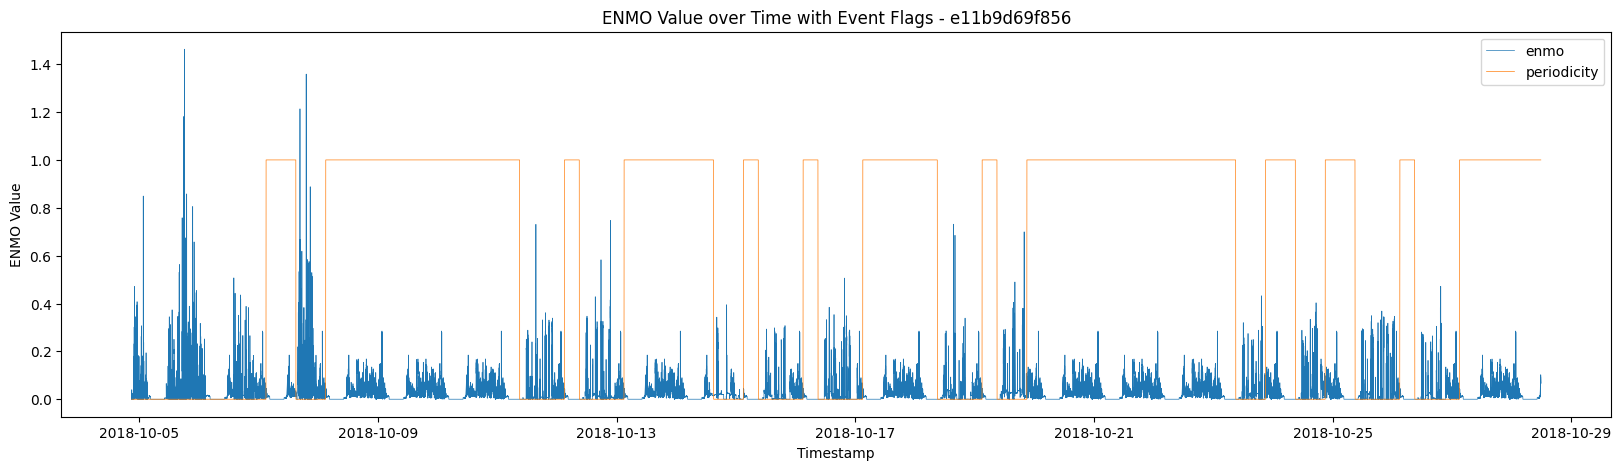

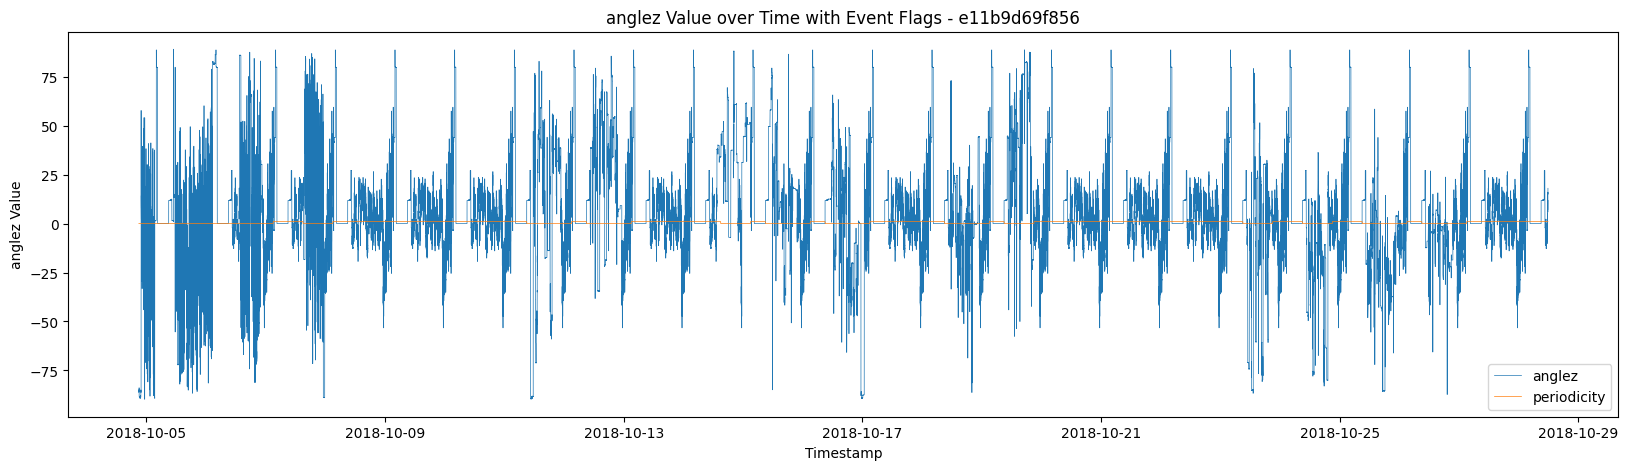

In [31]:
series_id = 'e11b9d69f856'
sample_serie = dfs[series_id]
plot_series_prob_with_events(series_id, sample_serie, train_events, oof_event_df)

In [ ]:
# 周期性が無いのに欠損しているのが顕著なもの
"05e1944c3818", "13b4d6a01d27", "a596ad0b82aa"

'03d92c9f6f8a'